In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from subprocess import STDOUT, check_output
import os
import random
from functools import reduce, partial

In [37]:
def extract_params( filename ):
    ''' Given a string of the form output_wgs%i_%s.out, returns the number encoded
        in %i and the string encoded in %s as a tuple.
    '''
    split = filename.split( '_' )
    return int( split[ 1 ][ 3 : ] ), split[ 2 ][ : -4 ]

def extract_runtime( filepath ):
    
    f = open( filepath, 'r' )
    lines = list( map( lambda s : s.split(), f.readlines() ) )
    cond = lambda l : len(l) == 4 and l[0] == 'Elapsed' and l[1] == 'time:'
    
    try:
        time = float( list( filter( cond, lines ) )[0][2] )
        f.close()
        return time
    except:
        f.close()
    
def process_output_files( folder ):
    
    out_files = [ f for f in os.listdir( folder ) if f[ -3 : ] == 'out' ]
    data = []
    
    for filename in out_files:
        n, dim = extract_params( filename )
        time = extract_runtime( '%s%s' % ( folder, filename ) )
        if time != None:
            data.append( (n, str( dim ), time) )

    data.sort( key = lambda x : x[0] )
    keys = list(set( d for n, d, t in data ))
    lines = dict( (k, ([], [])) for k in keys )
    
    for (n, d, t) in data:
        lines[ d ][ 0 ].append( n )
        lines[ d ][ 1 ].append( t )

    return lines

def runtime_to_speedup( data ):
    basetimes = { '128x128' : 38, '128x256' : 78, '256x256' : 312, '1024x1024' : 1743 }
    return dict( (k, (xs, [ basetimes[k] / t for t in ys ])) 
                 for (k, (xs, ys)) in data.items() )

In [67]:
def plot_scatter( lines, title = '' ):
    
    colors = [ 'red', 'green', 'blue', 'cyan' ]
    fig = plt.figure()
    ax = fig.add_subplot( 111 )
    
    for ( k, args ) in lines.items():
        ax.scatter( *args, c = colors.pop(), label = k )
        
    ax.legend( loc = 1 )
    ax.set_xlabel( 'number of processes' )
    ax.set_ylabel( 'runtime (s)' )
    ax.set_title( title )
    plt.show()
    
def plot_bars( data, figsize = (8, 6), legendloc = 0 ):
    xs = list(set(sum( (x for k, (x, y) in data.items()), [] )))
    xs.sort()
    N = len( xs )
    ind = np.arange( N )  # the x locations for the groups
    width = 0.35   
    
    fig, ax = plt.subplots( figsize = figsize )
    keys = [ '1024x1024', '256x256', '128x256', '128x128' ]
    colors = [ 'r', 'g', 'b', 'c' ]
    barGroups = []
    for i, k in enumerate( keys ):
        xyMap = dict(zip(*data[k]))
        ys = [ xyMap[x] for x in xs ]
        barGroups.append(ax.bar( ind + (i+1)*width/2, ys, width/2, color=colors.pop(0) ))
    
    ax.legend( [ group[0] for group in barGroups ], keys, loc = legendloc )
    ax.set_xticks( ind + 1.25 * width )
    ax.set_xticklabels( xs )

    return ax

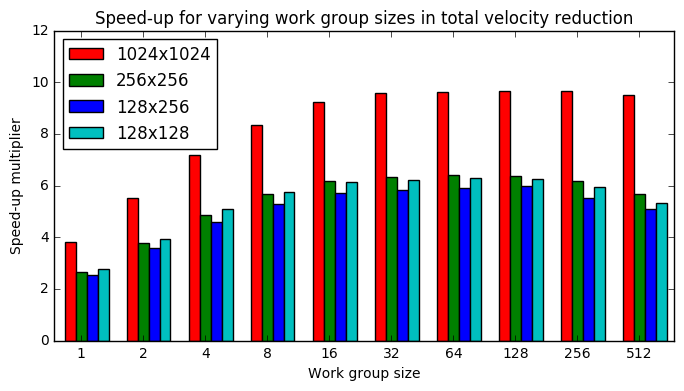

In [72]:
data = process_output_files( './tests/test2/' )
ax = plot_bars( runtime_to_speedup(data), (8, 4) )
ax.set_title( 'Speed-up for varying work group sizes in total velocity reduction' )
ax.set_ylabel( 'Speed-up multiplier' )
ax.set_xlabel( 'Work group size')
ax.set_ylim([0, 12])
plt.show()